LSTM Stock price prediction

In [1]:
#Import all the libraries required
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import yfinance as yf


In [2]:
#download the stock data from 2015 to 2023
stock_data = yf.download('TSLA', start = '2015-01-01', end= '2023-12-01')
stock_data.columns = stock_data.columns.droplevel(1)
print(stock_data.columns)
print(stock_data)

/tmp/ipython-input-2-3592554704.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download('TSLA', start = '2015-01-01', end= '2023-12-01')
[*********************100%***********************]  1 of 1 completed

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')
Price            Close        High         Low        Open     Volume
Date                                                                 
2015-01-02   14.620667   14.883333   14.217333   14.858000   71466000
2015-01-05   14.006000   14.433333   13.810667   14.303333   80527500
2015-01-06   14.085333   14.280000   13.614000   14.004000   93928500
2015-01-07   14.063333   14.318667   13.985333   14.223333   44526000
2015-01-08   14.041333   14.253333   14.000667   14.187333   51637500
...                ...         ...         ...         ...        ...
2023-11-24  235.449997  238.750000  232.330002  233.750000   65125200
2023-11-27  236.080002  238.330002  232.100006  236.889999  112031800
2023-11-28  246.720001  247.000000  234.009995  236.679993  148549900
2023-11-29  244.139999  252.750000  242.759995  249.210007  135401300
2023-11-30  240.080002  245.220001  236.910004  245.139999  132353200

[2244 row

In [3]:
#Get the number of rows and column
stock_data.shape

(2244, 5)

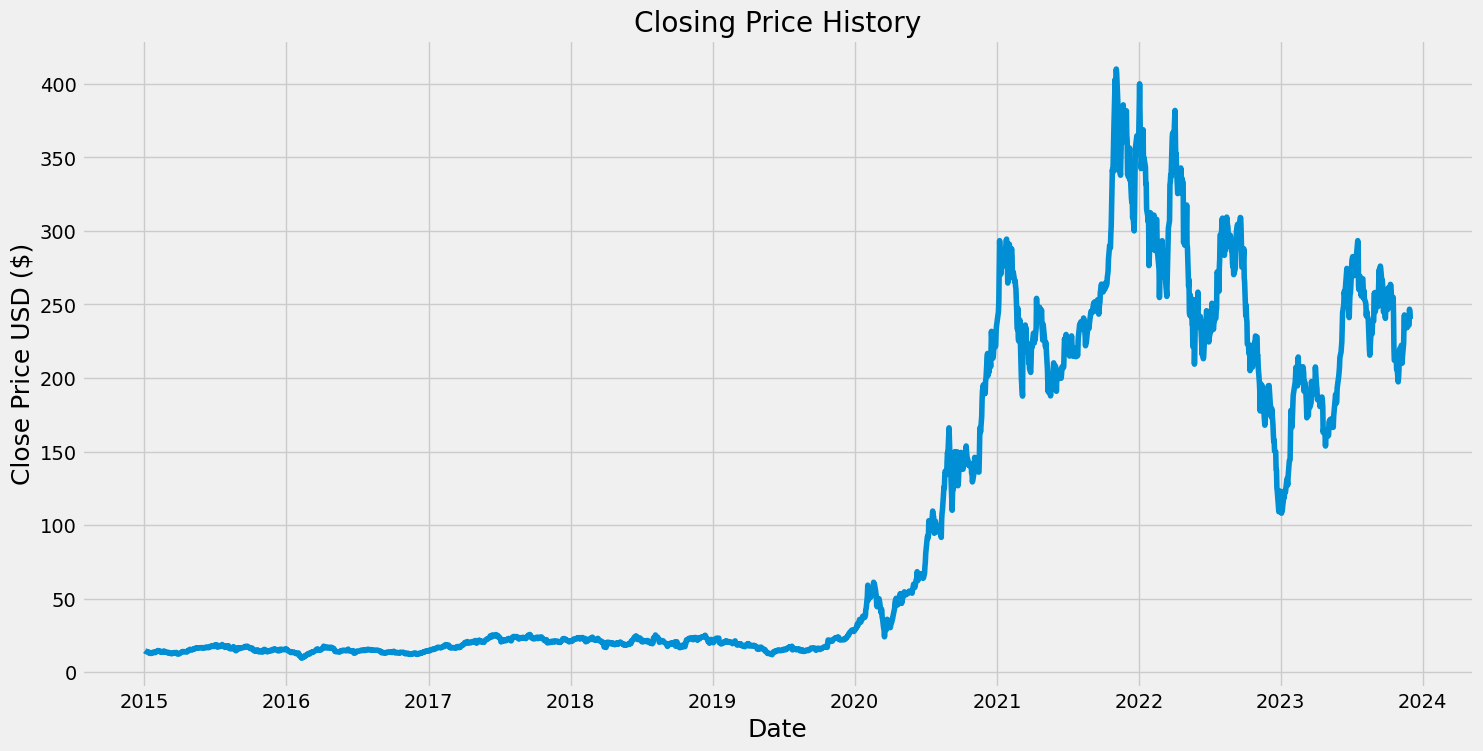

In [4]:
#Plot the closing price of the stocks
plt.figure(figsize=(16,8))
plt.title('Closing Price History')
plt.plot(stock_data['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

In [5]:
#Get the closing price column
closing_data = stock_data.filter(['Close'])
#Convert the data into numpy array
dataset = closing_data.values
#training dataset which has 80% of the closing price, remaining we use it as testing data
training_data_len = math.ceil(len(dataset)*0.8)
training_data_len

1796

In [6]:
#Scale the data so that each data is treated equally without any bias
scaler= MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.01259433],
       [0.01105916],
       [0.0112573 ],
       ...,
       [0.59227457],
       [0.58583088],
       [0.57569083]])

In [7]:
#form the training dataset, training data contains value up to 1796
training_dataset = scaled_data[0:training_data_len,:]
#Split the training data
x_train =[]
y_train = []
for i in range(60,training_data_len):
  #x_train contains the value form 0:59 cause we are predicting the stock on the basis of last 60 days closing price
  x_train.append(training_dataset[i-60:i,0])
  y_train.append(training_dataset[i,0])
  if(i<=60):
    print(x_train)
    print(y_train)

[array([0.01259433, 0.01105916, 0.0112573 , 0.01120235, 0.01114741,
       0.01048805, 0.00974712, 0.01008678, 0.008162  , 0.00802547,
       0.00822527, 0.00803546, 0.00880803, 0.00964888, 0.00959393,
       0.01046974, 0.01037483, 0.00927424, 0.01024496, 0.00997855,
       0.01120069, 0.01243614, 0.01246778, 0.01287405, 0.01226964,
       0.01228962, 0.01209148, 0.01151039, 0.00985867, 0.01000686,
       0.01010343, 0.01012175, 0.0113289 , 0.01222802, 0.01060128,
       0.01006347, 0.01000519, 0.0105763 , 0.00993526, 0.00893458,
       0.00930588, 0.00978541, 0.00948404, 0.00836014, 0.00786063,
       0.00776739, 0.00833683, 0.00789227, 0.00749432, 0.00866318,
       0.00850167, 0.00949736, 0.00865485, 0.00905945, 0.00931754,
       0.00966553, 0.00843007, 0.00778237, 0.00688159, 0.00780901])]
[np.float64(0.007509308698712719)]


In [8]:
#Convert x_train and y_train into numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

In [9]:
#reshape x_train and y_train to 3D
x_train.ndim
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_train.shape

(1736, 60, 1)

In [10]:
#Build the LSTM model architecture
model = Sequential()
#add layer with 50 neuron and x_train as input
model.add(LSTM(50,return_sequences =True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
#add dense layer with 25 neuron
model.add(Dense(25))
model.add(Dense(1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
#Compile the model
model.compile(optimizer='adam',loss='mean_squared_error')

In [12]:
#Train the model
model.fit(x_train,y_train, batch_size=1,epochs=1)

1736/1736 ━━━━━━━━━━━━━━━━━━━━ 48s 25ms/step - loss: 0.0059


In [13]:
#create testing data
#Since we are using last 60 days stock use -60
testing_data = scaled_data[training_data_len-60:,:]
#split the testing data to x_test and y_test
x_test =[]
y_test = dataset[training_data_len:,:]
for i in range(60,len(testing_data)):
  x_test.append(testing_data[i-60:i,0])


In [14]:
#create a numpy array
x_test = np.array(x_test)

In [15]:
#reshape x test
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [16]:
#predict
prediction = model.predict(x_test)
#inverse the scaling
prediction = scaler.inverse_transform(prediction)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [17]:
#find root mean square error
rmse = np.sqrt(np.mean(prediction-y_test)**2)
rmse

np.float64(2.006107432501657)

/tmp/ipython-input-18-61495451.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing['Predictions'] = prediction


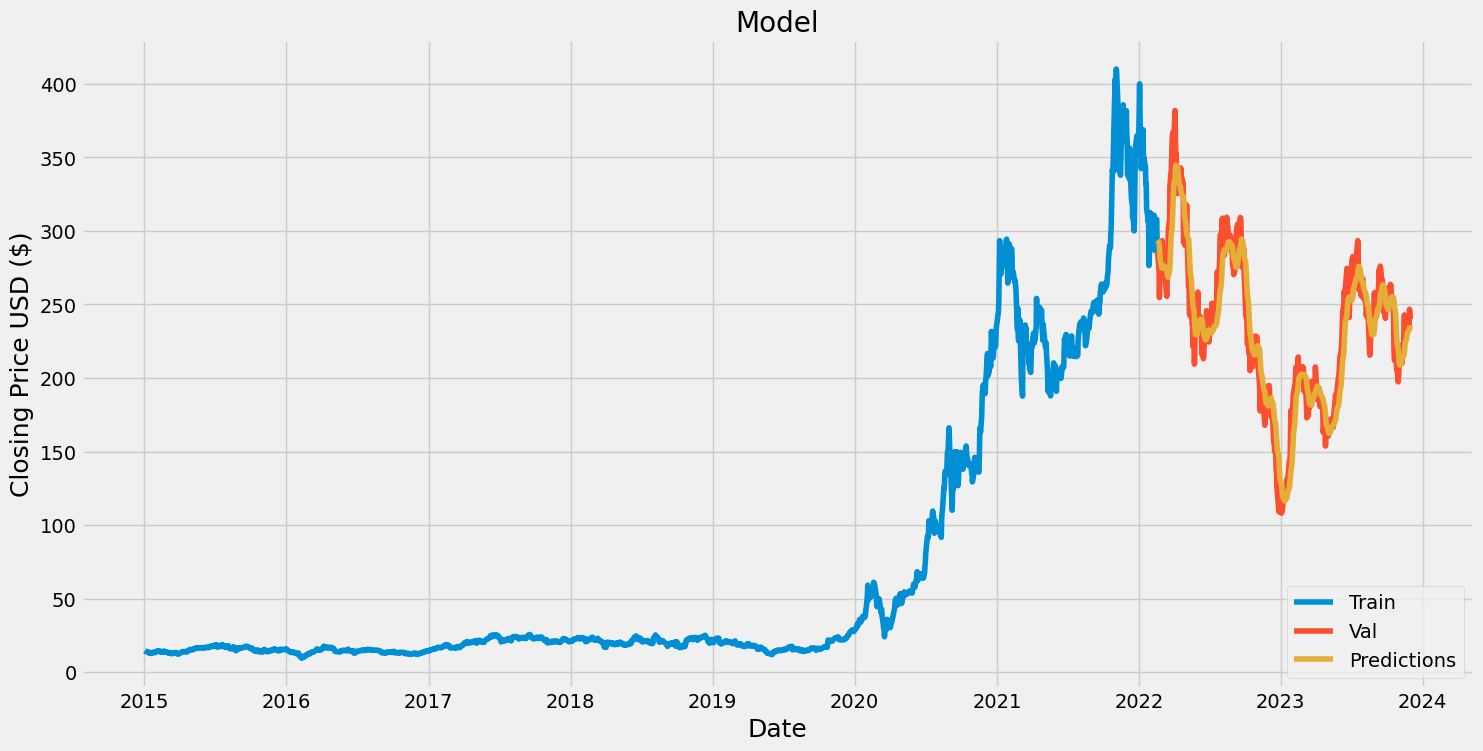

In [18]:
#seperate to training and testing and plot
train = closing_data[:training_data_len]
testing = closing_data[training_data_len:]
testing['Predictions'] = prediction

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Closing Price USD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(testing[['Close','Predictions']])
plt.legend(['Train','Val','Predictions'],loc='lower right')
plt.show()

In [19]:
testing

,Close,Predictions
Date,,
2022-02-18,285.660004,293.616302
2022-02-22,273.843323,292.171844
2022-02-23,254.679993,289.420258
2022-02-24,266.923340,284.680420
2022-02-25,269.956665,280.168915
...,...,...
2023-11-24,235.449997,231.526154
2023-11-27,236.080002,232.500092
2023-11-28,246.720001,233.192398
